Using tickers → HUL_IN: HINDUNILVR.NS | ULVR_UK: ULVR.L
Return correlation over overlap (D): 0.116


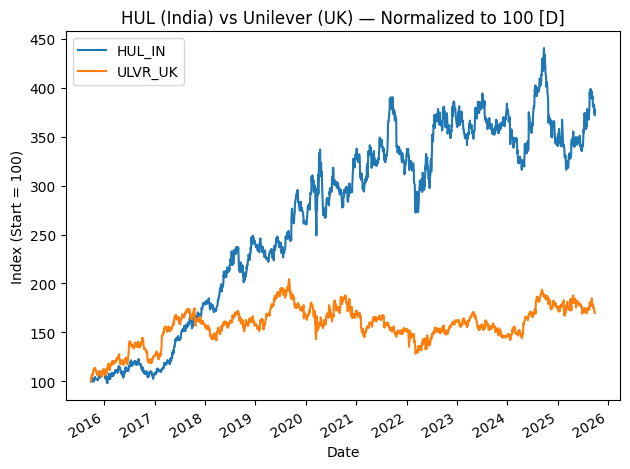

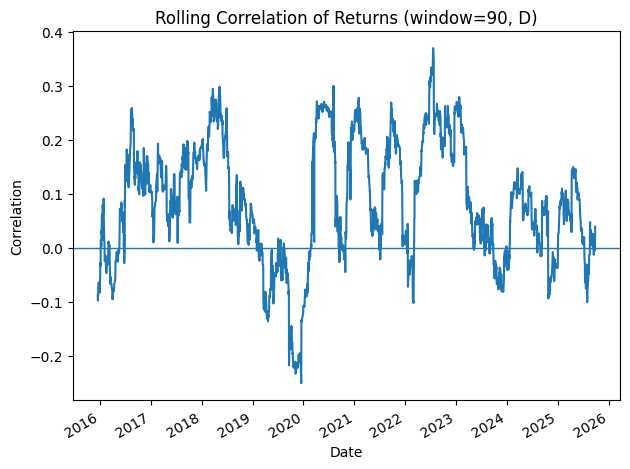

In [5]:
# Compare Hindustan Unilever (India) vs Unilever PLC (UK) robustly
# Requirements: pip install yfinance pandas matplotlib

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Candidate tickers: primary then fallbacks
candidates = {
    "HUL_IN": ["HINDUNILVR.NS", "HINDUNILVR.BO"],
    "ULVR_UK": ["ULVR.L", "ULVR"]  # ULVR.L (LSE), UL (NYSE ADR) if you prefer: ["ULVR.L", "UL"]
}

# 1) Pull clean "Close" series with date-only index; try fallbacks if needed
series = {}
chosen = {}
for name, ticker_list in candidates.items():
    s = None
    for t in ticker_list:
        h = yf.Ticker(t).history(period="10y", interval="1d", auto_adjust=True)
        if not h.empty and "Close" in h and h["Close"].dropna().shape[0] > 0:
            s = h["Close"].dropna()
            # normalize index to date only, drop tz
            s.index = s.index.tz_convert(None) if s.index.tz is not None else s.index
            s.index = s.index.tz_localize(None) if getattr(s.index, "tz", None) is not None else s.index
            s.index = s.index.normalize()
            chosen[name] = t
            break
    if s is None:
        raise ValueError(f"No data for {name} from candidates: {ticker_list}")
    series[name] = s

print(f"Using tickers → HUL_IN: {chosen['HUL_IN']} | ULVR_UK: {chosen['ULVR_UK']}")

# 2) Merge on common dates (inner join)
daily = pd.concat(series, axis=1, join="inner").dropna()
daily.columns = ["HUL_IN", "ULVR_UK"]

# 3) If no daily overlap, fall back to weekly (last price of week)
if daily.empty:
    hul_w = series["HUL_IN"].resample("W-FRI").last().dropna()
    ulvr_w = series["ULVR_UK"].resample("W-FRI").last().dropna()
    weekly = pd.concat([hul_w, ulvr_w], axis=1, join="inner").dropna()
    weekly.columns = ["HUL_IN", "ULVR_UK"]
    if weekly.empty:
        raise ValueError("No overlapping dates even after weekly resample. "
                         "Try a longer period or check connectivity to Yahoo.")
    prices = weekly
    window = 26  # ~6 months weekly
    freq_label = "W-FRI"
else:
    prices = daily
    window = 90  # ~3 months daily
    freq_label = "D"

# 4) Rebase to 100 on first common date
base = prices.iloc[0]
norm = prices / base * 100

# 5) Correlation on returns (not prices) + rolling correlation
rets = prices.pct_change().dropna()
full_corr = rets["HUL_IN"].corr(rets["ULVR_UK"])
print(f"Return correlation over overlap ({freq_label}): {full_corr:.3f}")

roll_corr = rets["HUL_IN"].rolling(window, min_periods=window//2).corr(rets["ULVR_UK"])

# 6) Plots
norm.plot(title=f"HUL (India) vs Unilever (UK) — Normalized to 100 [{freq_label}]")
plt.ylabel("Index (Start = 100)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

roll_corr.plot(title=f"Rolling Correlation of Returns (window={window}, {freq_label})")
plt.axhline(0, linewidth=1)
plt.ylabel("Correlation")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


Daily return correlation over overlap: 0.551


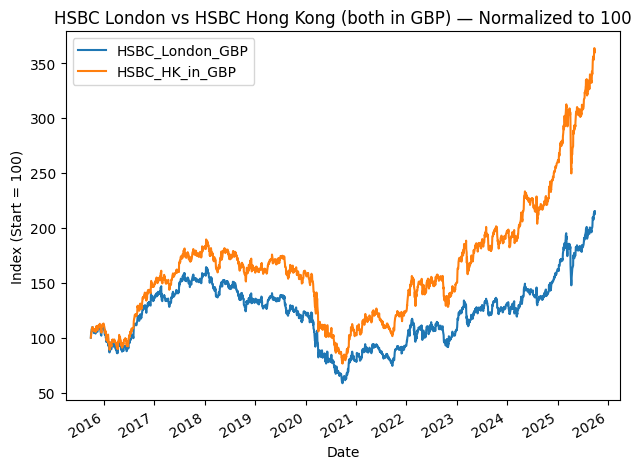

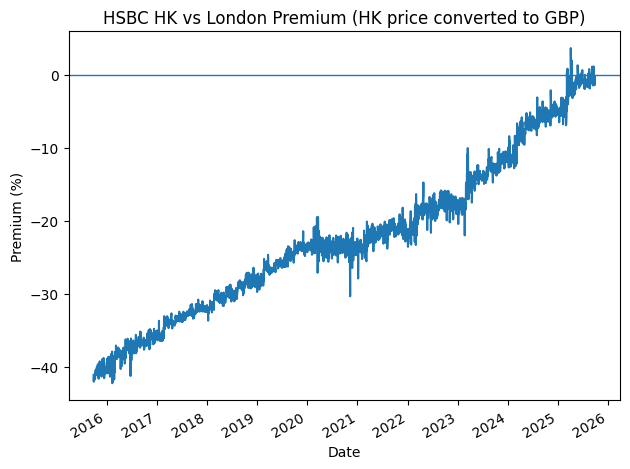

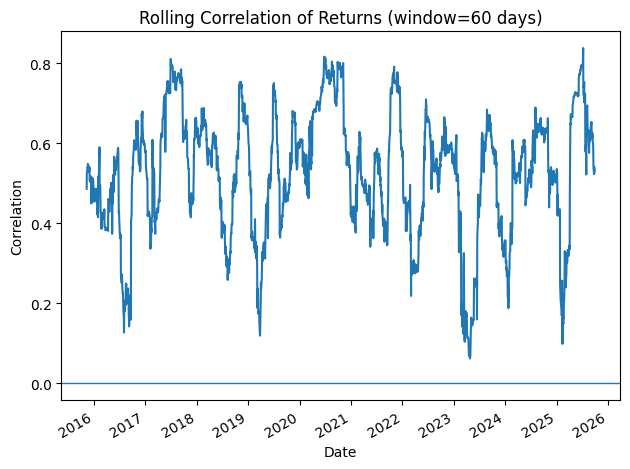

In [1]:
# Requirements: pip install yfinance pandas matplotlib

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# 1) Download daily data (10y) for HSBC London, HSBC Hong Kong, and FX GBPHKD
tickers = {
    "LON_GBp": "HSBA.L",      # HSBC in London, quoted in GBp (pence)
    "HKG_HKD": "0005.HK",     # HSBC in Hong Kong, quoted in HKD
    "GBPHKD": "GBPHKD=X"      # FX rate: 1 GBP = X HKD
}

data = {}
for k, t in tickers.items():
    h = yf.Ticker(t).history(period="10y", interval="1d", auto_adjust=True)["Close"].dropna()
    h.index = h.index.tz_localize(None)
    h.index = h.index.normalize()
    data[k] = h

# 2) Merge on common dates
df = pd.concat([data["LON_GBp"], data["HKG_HKD"], data["GBPHKD"]], axis=1, join="inner")
df.columns = ["LON_GBp", "HKG_HKD", "GBPHKD"]
df = df.dropna()

# 3) Convert both listings to GBP
# London is quoted in GBp (pence). Convert to GBP by dividing by 100.
lon_gbp = df["LON_GBp"] / 100.0

# Hong Kong is in HKD. Convert to GBP using GBPHKD (HKD per GBP), so HKD / (HKD per GBP) = GBP
hkg_gbp = df["HKG_HKD"] / df["GBPHKD"]

prices_gbp = pd.DataFrame({"HSBC_London_GBP": lon_gbp, "HSBC_HK_in_GBP": hkg_gbp}).dropna()

# 4) Rebase to 100 for comparability
base = prices_gbp.iloc[0]
norm = prices_gbp / base * 100.0

# 5) Correlation of daily returns and a rolling correlation
rets = prices_gbp.pct_change().dropna()
full_corr = rets["HSBC_London_GBP"].corr(rets["HSBC_HK_in_GBP"])
print(f"Daily return correlation over overlap: {full_corr:.3f}")

window = 60  # ~3 months of trading days
roll_corr = rets["HSBC_London_GBP"].rolling(window, min_periods=window//2).corr(rets["HSBC_HK_in_GBP"])

# 6) Premium: how much HK-in-GBP deviates from London in % terms
premium = (prices_gbp["HSBC_HK_in_GBP"] / prices_gbp["HSBC_London_GBP"] - 1.0) * 100.0

# 7) Plots
norm.plot(title="HSBC London vs HSBC Hong Kong (both in GBP) — Normalized to 100")
plt.ylabel("Index (Start = 100)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

premium.plot(title="HSBC HK vs London Premium (HK price converted to GBP)", ylabel="Premium (%)")
plt.axhline(0, linewidth=1)
plt.xlabel("Date")
plt.tight_layout()
plt.show()

roll_corr.plot(title=f"Rolling Correlation of Returns (window={window} days)")
plt.axhline(0, linewidth=1)
plt.ylabel("Correlation")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


[*********************100%***********************]  2 of 2 completed


Pair trading: SHEL.L vs BP.L
Start margin per leg: £20, Exposure per leg: £100
Total P&L over period: £4.18
Number of trades (entries+exits): 38


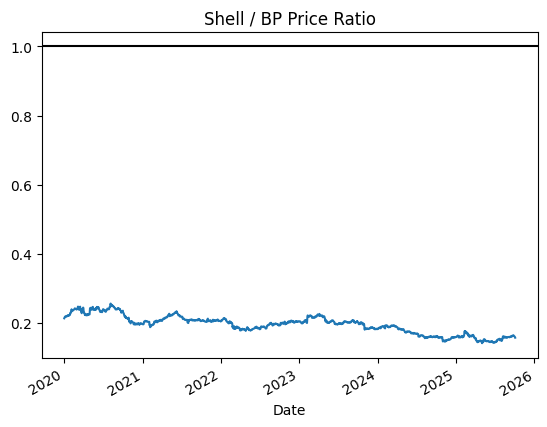

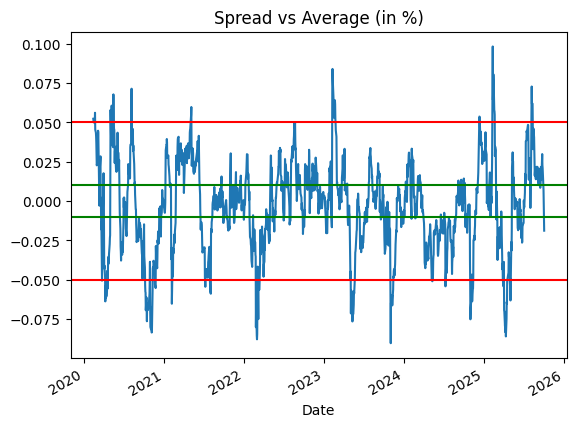

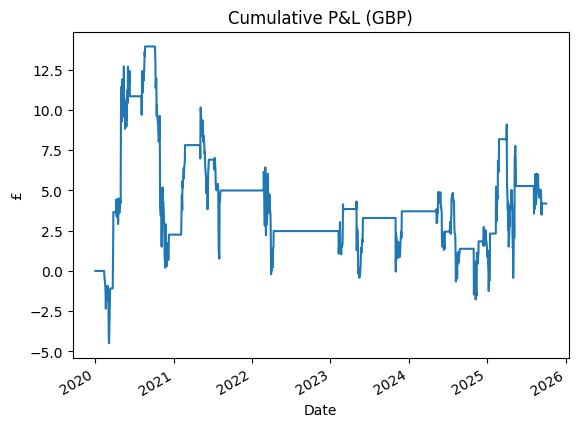

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
stockA, stockB = "SHEL.L", "BP.L"   # Shell vs BP
notional = 100                      # £100 per leg (your CFD exposure)
margin = 20                         # what you actually put down per leg
window = 30                         # rolling days for average ratio
entry = 0.05                        # enter if ratio deviates >5%
exit = 0.01                         # exit if ratio closes to within 1%
start = "2020-01-01"

# ---------------- DATA ------------------
px = yf.download([stockA, stockB], start=start, auto_adjust=True)["Close"].dropna()
px.columns = ["A","B"]

ratio = px["A"] / px["B"]
mean = ratio.rolling(window).mean()
spread = ratio / mean - 1   # deviation from average in %

rets = px.pct_change().fillna(0.0)

# ---------------- STRATEGY --------------
pos = pd.Series(0, index=px.index)   # +1 = long A/short B ; -1 = short A/long B ; 0 = flat
in_trade = 0

for i in range(len(spread)):
    if pd.isna(spread.iloc[i]):  # wait for rolling mean ready
        pos.iloc[i] = in_trade
        continue
    if in_trade == 0:
        if spread.iloc[i] > entry:   # A expensive vs B
            in_trade = -1
        elif spread.iloc[i] < -entry: # A cheap vs B
            in_trade = +1
    else:
        if abs(spread.iloc[i]) < exit:  # exit when ratio normalises
            in_trade = 0
    pos.iloc[i] = in_trade

# P&L: £100 per leg, so return = 100 * (ret_A - ret_B)*pos
pnl = notional * pos.shift().fillna(0) * (rets["A"] - rets["B"])
equity = pnl.cumsum()

# ---------------- RESULTS ----------------
print(f"Pair trading: {stockA} vs {stockB}")
print(f"Start margin per leg: £{margin}, Exposure per leg: £{notional}")
print(f"Total P&L over period: £{equity.iloc[-1]:.2f}")
print(f"Number of trades (entries+exits): {int(pos.diff().abs().sum())}")

# ---------------- PLOTS -----------------
ratio.plot(title="Shell / BP Price Ratio")
plt.axhline(1, color="black"); plt.show()

spread.plot(title="Spread vs Average (in %)")
plt.axhline(entry, color="red"); plt.axhline(-entry, color="red")
plt.axhline(exit, color="green"); plt.axhline(-exit, color="green")
plt.show()

equity.plot(title="Cumulative P&L (GBP)")
plt.ylabel("£"); plt.show()


[*********************100%***********************]  2 of 2 completed


<Figure size 1000x500 with 0 Axes>

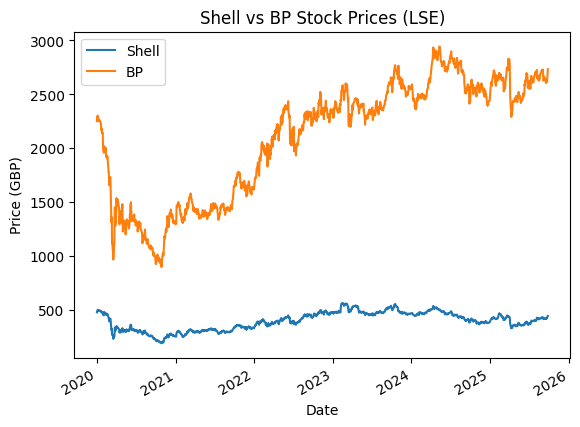

<Figure size 1000x500 with 0 Axes>

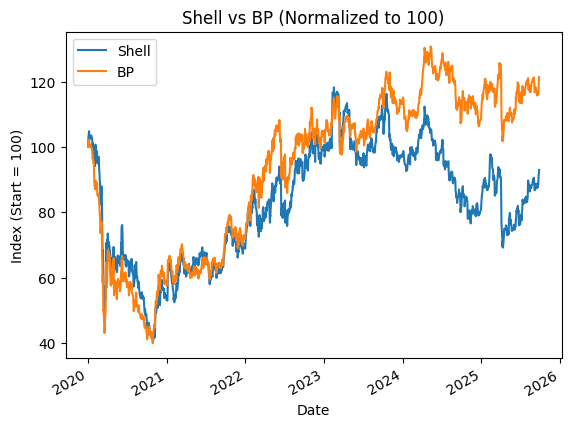

In [4]:
import yfinance as yf
import matplotlib.pyplot as plt

# Download Shell and BP daily prices
px = yf.download(["SHEL.L", "BP.L"], start="2020-01-01", auto_adjust=True)["Close"].dropna()
px.columns = ["Shell","BP"]

# Plot actual prices
plt.figure(figsize=(10,5))
px.plot(title="Shell vs BP Stock Prices (LSE)")
plt.ylabel("Price (GBP)")
plt.show()

# Normalize both to 100 at the start, to compare performance
norm = px / px.iloc[0] * 100
plt.figure(figsize=(10,5))
norm.plot(title="Shell vs BP (Normalized to 100)")
plt.ylabel("Index (Start = 100)")
plt.show()


[*********************100%***********************]  2 of 2 completed


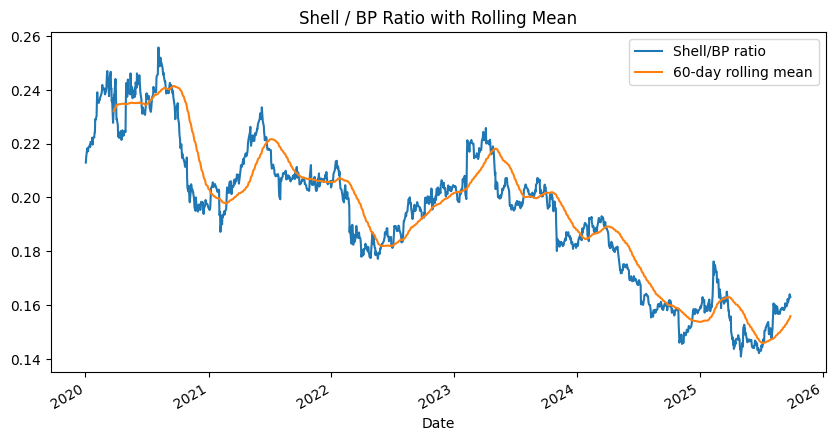

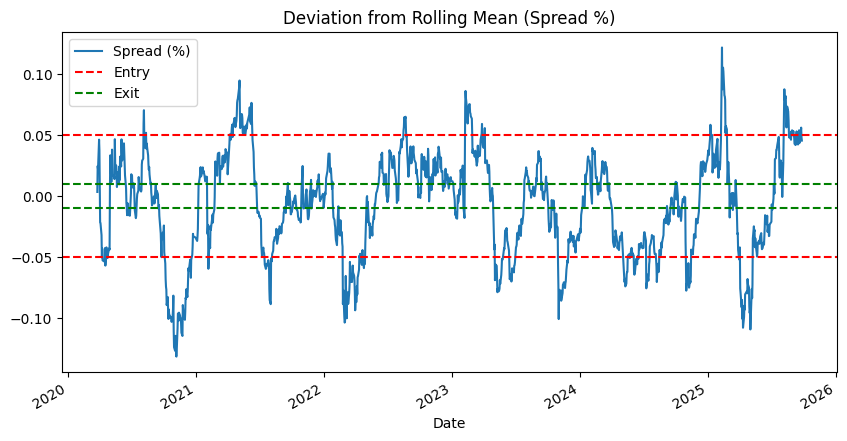

In [5]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Download Shell and BP
px = yf.download(["SHEL.L", "BP.L"], start="2020-01-01", auto_adjust=True)["Close"].dropna()
px.columns = ["Shell","BP"]

# Ratio
ratio = px["Shell"] / px["BP"]

# Parameters you can tune
window = 60    # rolling lookback days (try 30, 90, 120)
entry = 0.05   # 5% deviation for entry (try 0.03, 0.10)
exit = 0.01    # 1% deviation for exit (try 0.005, 0.02)

# Rolling mean + spread
mean = ratio.rolling(window).mean()
spread = ratio / mean - 1   # % deviation from rolling mean

# Plot ratio with rolling mean
plt.figure(figsize=(10,5))
ratio.plot(label="Shell/BP ratio")
mean.plot(label=f"{window}-day rolling mean")
plt.legend()
plt.title("Shell / BP Ratio with Rolling Mean")
plt.show()

# Plot spread with entry/exit bands
plt.figure(figsize=(10,5))
spread.plot(label="Spread (%)")
plt.axhline(entry, color="red", linestyle="--", label="Entry")
plt.axhline(-entry, color="red", linestyle="--")
plt.axhline(exit, color="green", linestyle="--", label="Exit")
plt.axhline(-exit, color="green", linestyle="--")
plt.legend()
plt.title("Deviation from Rolling Mean (Spread %)")
plt.show()


[*********************100%***********************]  2 of 2 completed

Pair: SHEL.L vs BP.L
Exposure: £100 per leg | Margin used: £20
Total profit over period: £1.75
Number of trades: 9

Sample trade log:
(Timestamp('2025-02-12 00:00:00'), 'ENTRY short Shell / long BP')
(Timestamp('2025-02-25 00:00:00'), 'EXIT')
(Timestamp('2025-03-04 00:00:00'), 'ENTRY long Shell / short BP')
(Timestamp('2025-03-10 00:00:00'), 'EXIT')
(Timestamp('2025-03-25 00:00:00'), 'ENTRY long Shell / short BP')
(Timestamp('2025-05-09 00:00:00'), 'EXIT')
(Timestamp('2025-05-12 00:00:00'), 'ENTRY short Shell / long BP')
(Timestamp('2025-05-15 00:00:00'), 'EXIT')
(Timestamp('2025-06-06 00:00:00'), 'ENTRY long Shell / short BP')
(Timestamp('2025-06-12 00:00:00'), 'EXIT')


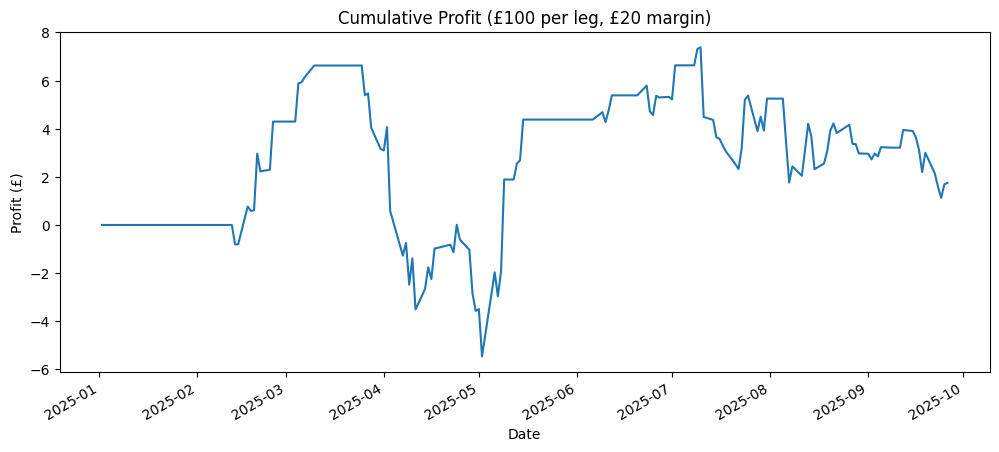

In [17]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
a, b = "SHEL.L", "BP.L"
window = 30
z_entry = 1.0
notional = 100   # £100 exposure per leg
margin = 20      # margin you put up per leg
start = "2025-01-01"

# ---------------- DATA ------------------
px = yf.download([a, b], start=start, auto_adjust=True)["Close"].dropna()
px.columns = ["Shell","BP"]

ratio = px["Shell"] / px["BP"]
mean = ratio.rolling(window).mean()
std = ratio.rolling(window).std()
z = (ratio - mean) / std
rets = px.pct_change().fillna(0)

# ---------------- STRATEGY --------------
pos = pd.Series(0, index=ratio.index)
signals, pnl = [], []
exit_threshold = 0.5

in_trade = 0
for i in range(len(z)):
    date = z.index[i]
    if pd.isna(z.iloc[i]):
        pnl.append(0); continue
    
    # Entry
    if in_trade == 0:
        if z.iloc[i] > z_entry:
            in_trade = -1
            signals.append((date, "ENTRY short Shell / long BP"))
        elif z.iloc[i] < -z_entry:
            in_trade = +1
            signals.append((date, "ENTRY long Shell / short BP"))
    
    # Exit
    elif (in_trade == 1 and z.iloc[i] >= -exit_threshold) or (in_trade == -1 and z.iloc[i] <= exit_threshold):
        signals.append((date, "EXIT"))
        in_trade = 0
    
    pos.iloc[i] = in_trade
    pnl.append(notional * pos.iloc[i-1] * (rets["Shell"].iloc[i] - rets["BP"].iloc[i]))

# ---------------- RESULTS ----------------
pnl = pd.Series(pnl, index=ratio.index)
equity = pnl.cumsum()

print(f"Pair: {a} vs {b}")
print(f"Exposure: £{notional} per leg | Margin used: £{margin}")
print(f"Total profit over period: £{equity.iloc[-1]:.2f}")
print(f"Number of trades: {len([s for s in signals if 'ENTRY' in s[1]])}")
print("\nSample trade log:")
for s in signals[:10]:  # show first 10 signals
    print(s)

# ---------------- PLOTS -----------------
plt.figure(figsize=(12,5))
equity.plot(title="Cumulative Profit (£100 per leg, £20 margin)")
plt.ylabel("Profit (£)")
plt.show()


In [18]:
import itertools

# Define ranges to search
windows = [10, 20, 30, 40, 60, 90]
z_entries = [0.5, 1.0, 1.5, 2.0]
exit_thresholds = [0.2, 0.5, 0.8, 1.0]

best_config = None
best_profit = -1e9

results = []

for w, ze, xt in itertools.product(windows, z_entries, exit_thresholds):
    # --- Re-run strategy for each config ---
    mean = ratio.rolling(w).mean()
    std = ratio.rolling(w).std()
    z = (ratio - mean) / std
    
    pos = pd.Series(0, index=ratio.index)
    pnl = []
    in_trade = 0
    
    for i in range(len(z)):
        if pd.isna(z.iloc[i]):
            pnl.append(0); continue
        if in_trade == 0:
            if z.iloc[i] > ze:
                in_trade = -1
            elif z.iloc[i] < -ze:
                in_trade = +1
        elif (in_trade == 1 and z.iloc[i] >= -xt) or (in_trade == -1 and z.iloc[i] <= xt):
            in_trade = 0
        pos.iloc[i] = in_trade
        pnl.append(notional * pos.iloc[i-1] * (rets["Shell"].iloc[i] - rets["BP"].iloc[i]))
    
    pnl = pd.Series(pnl, index=ratio.index)
    equity = pnl.cumsum()
    profit = equity.iloc[-1]
    
    results.append((w, ze, xt, profit))
    
    if profit > best_profit:
        best_profit = profit
        best_config = (w, ze, xt)

# Sort results by profit
results_sorted = sorted(results, key=lambda x: x[3], reverse=True)

print("Top 5 configs by profit:")
for r in results_sorted[:5]:
    print(f"window={r[0]}, z_entry={r[1]}, exit_threshold={r[2]} | Profit: £{r[3]:.2f}")

print("\nBest configuration overall:")
print(f"window={best_config[0]}, z_entry={best_config[1]}, exit_threshold={best_config[2]} | Profit: £{best_profit:.2f}")


Top 5 configs by profit:
window=30, z_entry=2.0, exit_threshold=0.2 | Profit: £6.52
window=30, z_entry=2.0, exit_threshold=0.5 | Profit: £5.68
window=30, z_entry=1.0, exit_threshold=0.2 | Profit: £3.97
window=10, z_entry=2.0, exit_threshold=1.0 | Profit: £3.42
window=30, z_entry=2.0, exit_threshold=0.8 | Profit: £3.14

Best configuration overall:
window=30, z_entry=2.0, exit_threshold=0.2 | Profit: £6.52


In [25]:
import itertools

# Define ranges to search
windows = [90]
z_entries = [2.0, 2.1, 2.2, 2.3, 2.4]
exit_thresholds = [0.2, 0.1,0.05]   # kept for compatibility, but unused in daily trading

best_config = None
best_profit = -1e9

results = []

for w, ze, xt in itertools.product(windows, z_entries, exit_thresholds):
    # --- Re-run strategy for each config (daily close) ---
    mean = ratio.rolling(w).mean()
    std = ratio.rolling(w).std()
    z = (ratio - mean) / std
    
    pos = pd.Series(0, index=ratio.index)
    pnl = []
    trades = 0
    
    for i in range(1, len(z)):   # start from 1 so we have returns
        if pd.isna(z.iloc[i]):
            pnl.append(0)
            continue
        
        # Daily signal check
        if z.iloc[i] > ze:        # Shell expensive
            position = -1         # short Shell, long BP
            trades += 1
        elif z.iloc[i] < -ze:     # Shell cheap
            position = +1         # long Shell, short BP
            trades += 1
        else:
            position = 0          # no trade
        
        pos.iloc[i] = position
        
        # P&L for this day only (always close at end of day)
        pnl.append(notional * position * (rets["Shell"].iloc[i] - rets["BP"].iloc[i]))
    
    pnl = pd.Series(pnl, index=ratio.index[1:])
    equity = pnl.cumsum()
    profit = equity.iloc[-1]
    
    results.append((w, ze, xt, profit, trades))
    
    if profit > best_profit:
        best_profit = profit
        best_config = (w, ze, xt, trades)

# Sort results by profit
results_sorted = sorted(results, key=lambda x: x[3], reverse=True)

print("Top 5 configs by profit:")
for r in results_sorted[:5]:
    print(f"window={r[0]}, z_entry={r[1]}, exit_threshold={r[2]} | "
          f"Profit: £{r[3]:.2f} | Trades: {r[4]}")

print("\nBest configuration overall:")
print(f"window={best_config[0]}, z_entry={best_config[1]}, exit_threshold={best_config[2]} | "
      f"Profit: £{best_profit:.2f} | Trades: {best_config[3]}")


Top 5 configs by profit:
window=90, z_entry=2.2, exit_threshold=0.2 | Profit: £-3.27 | Trades: 7
window=90, z_entry=2.2, exit_threshold=0.1 | Profit: £-3.27 | Trades: 7
window=90, z_entry=2.2, exit_threshold=0.05 | Profit: £-3.27 | Trades: 7
window=90, z_entry=2.3, exit_threshold=0.2 | Profit: £-3.27 | Trades: 7
window=90, z_entry=2.3, exit_threshold=0.1 | Profit: £-3.27 | Trades: 7

Best configuration overall:
window=90, z_entry=2.2, exit_threshold=0.2 | Profit: £-3.27 | Trades: 7
